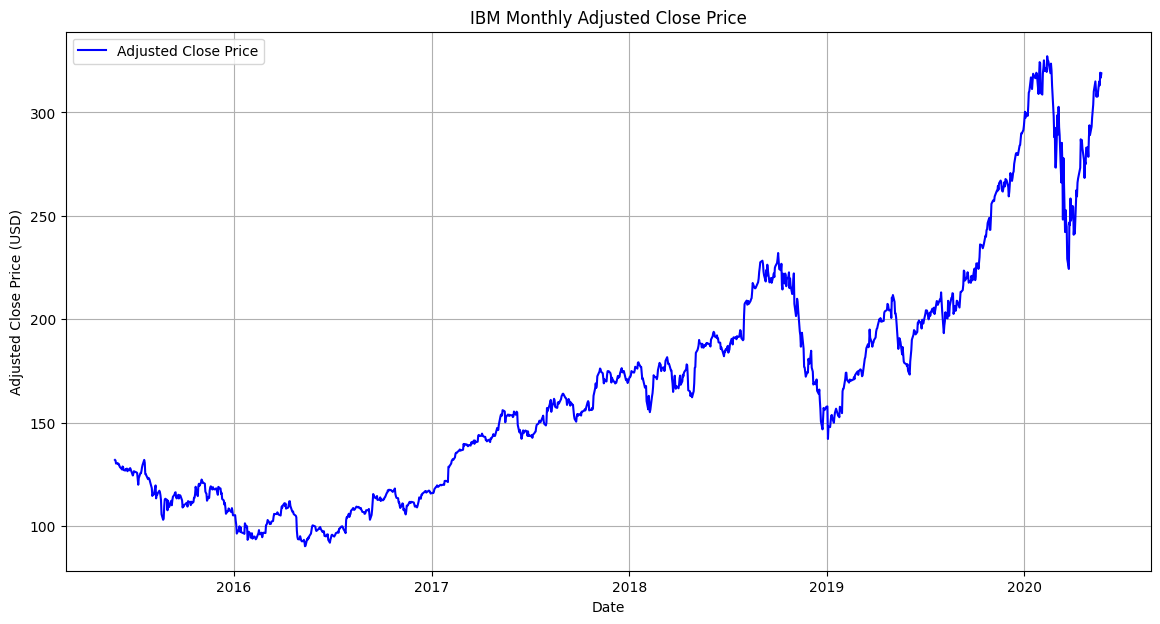

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = './AAPL.csv'
df = pd.read_csv(file_path)

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort the data by date
df = df.sort_values('date')

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Adjusted Close Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.title('IBM Monthly Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

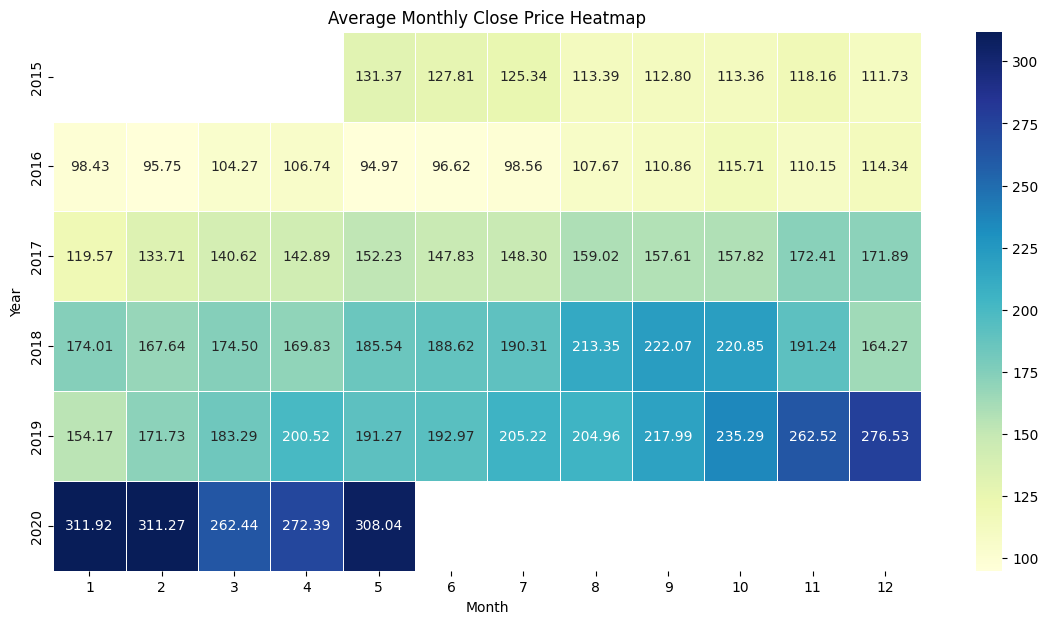

In [2]:
# Load the data
file_path = './AAPL.csv'
df = pd.read_csv(file_path)
# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort the data by date
df = df.sort_values('date')

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Extract year and month
df['year'] = df.index.year
df['month'] = df.index.month

# Aggregate the data to get the average close price for each year and month
heatmap_data = df.pivot_table(values='close', index='year', columns='month', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5)
plt.xlabel('Month')
plt.ylabel('Year')
plt.title('Average Monthly Close Price Heatmap')
plt.show()


In [3]:
#cleaning the data
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    df.set_index('date', inplace=True)
    return df.dropna()


In [4]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
    data = df.filter(['close'])
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Normalize the data
scaled_data, scaler = normalize_data(df)


In [5]:
def split_data(scaled_data, train_size=0.7, val_size=0.15):
    train_len = int(len(scaled_data) * train_size)
    val_len = int(len(scaled_data) * val_size)
    train_data = scaled_data[:train_len]
    val_data = scaled_data[train_len:train_len + val_len]
    test_data = scaled_data[train_len + val_len:]
    return train_data, val_data, test_data

# Split the data
train_data, val_data, test_data = split_data(scaled_data)


In [6]:
import numpy as np
def prepare_data(data, time_step=60):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    return x, y

# Prepare training data
x_train, y_train = prepare_data(train_data)

# Prepare validation data
x_val, y_val = prepare_data(val_data)


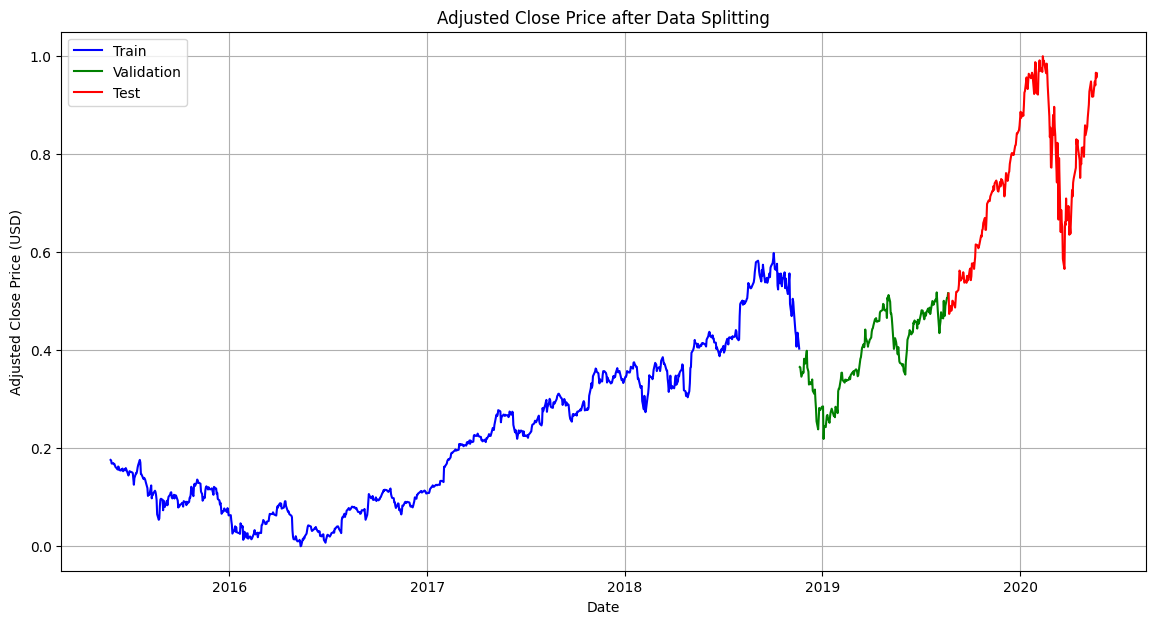

In [7]:
# Plotting the data after splitting
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(df.index[:len(train_data)], train_data, label='Train', color='blue')

# Plot validation data
plt.plot(df.index[len(train_data):len(train_data) + len(val_data)], val_data, label='Validation', color='green')

# Plot test data
plt.plot(df.index[len(train_data) + len(val_data):], test_data, label='Test', color='red')

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.title('Adjusted Close Price after Data Splitting')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.regularizers import l2

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')

In [52]:
# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/100
13/13 [==============================] - 12s 384ms/step - loss: 0.0172 - val_loss: 0.0015
Epoch 2/100
13/13 [==============================] - 4s 321ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 3/100
13/13 [==============================] - 5s 382ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/100
13/13 [==============================] - 4s 272ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/100
13/13 [==============================] - 3s 270ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/100
13/13 [==============================] - 5s 431ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7/100
13/13 [==============================] - 4s 281ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
13/13 [==============================] - 4s 274ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/100
13/13 [==============================] - 6s 440ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 10/100
13/13 [==============================] - 4s 305ms/step - loss: 0.0012 - val_l

5/5 [==============================] - 0s 37ms/step


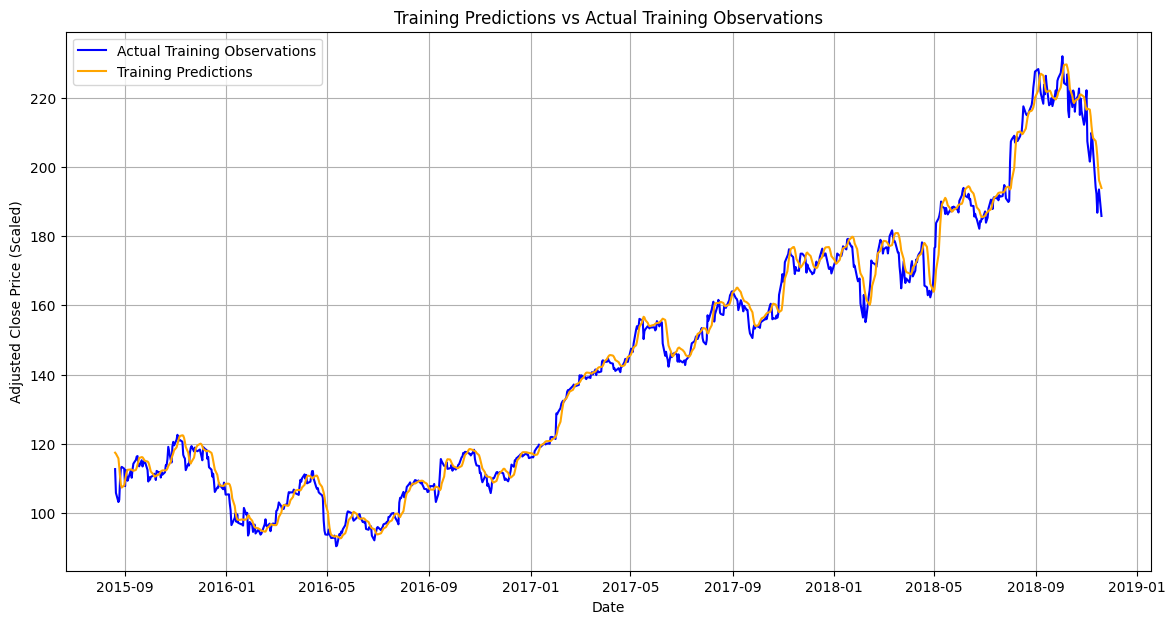

In [55]:
# Make predictions on training data
train_predictions = model.predict(x_train)

# Prepare testing data and corresponding actual values
x_test, y_test_actual = prepare_data(test_data)

# Make predictions on test data
test_predictions = model.predict(x_test)

# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test_actual.reshape(-1, 1))

# Plot training predictions vs actual
plt.figure(figsize=(14, 7))
plt.plot(df.index[60:60+len(y_train_actual)], y_train_actual, label='Actual Training Observations', color='blue')
plt.plot(df.index[60:60+len(train_predictions)], train_predictions, label='Training Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (Scaled)')
plt.title('Training Predictions vs Actual Training Observations')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
from sklearn.metrics import mean_squared_error
# Make predictions on training data
train_predictions = model.predict(x_train)

# Prepare testing data and corresponding actual values
def prepare_testing_data(test_data, time_step=60):
    x_test = []
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return x_test, test_data[time_step:]

# Prepare testing data and corresponding actual values
x_test, y_test_actual = prepare_testing_data(test_data)

# Make predictions on test data
test_predictions = model.predict(x_test)

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    return rmse, mse

# Calculate RMSE and MSE for training data
train_rmse, train_mse = calculate_metrics(y_train, train_predictions)
print(f'Training RMSE(Root mean squared error): {train_rmse}')
print(f'Training MSE(Mean squared error): {train_mse}')

# Calculate RMSE and MSE for test data
test_rmse, test_mse = calculate_metrics(y_test_actual, test_predictions)
print(f'Test RMSE(Root mean squared error): {test_rmse}')
print(f'Test MSE(Mean squared error): {test_mse}')


5/5 [==============================] - 0s 39ms/step
Training RMSE(Root mean squared error): 0.015249341362032452
Training MSE(Mean squared error): 0.00023254241197579378
Test RMSE(Root mean squared error): 0.04934254157126986
Test MSE(Mean squared error): 0.002434686408712494


In [57]:
import pickle

# Serialize (save) the trained model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Deserialize (load) the saved model
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model


# Saving  the trained model
save_model(model, 'trained_model.pkl')

# Loading the saved model
loaded_model = load_model('trained_model.pkl')
